In [1]:
import logging
import sys
from pathlib import Path


logging.basicConfig(
    level=logging.INFO,
    format="%(levelname)s: %(message)s",
    force=True,
)

# Add the src directory to the Python path
sys.path.append(str(Path.cwd().parent.parent))

In [2]:
from src.nas.chromosome import ChromosomeConfig
from src.nas.mlp_chromosome import MLPChromosome

ch_cfg = ChromosomeConfig(MLPChromosome)
low, high = ch_cfg.get_bounds()
low, high, ch_cfg.get_size()


(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([7, 3, 6, 7, 6, 7, 6, 7, 7, 3, 3, 0, 0, 0, 2, 0, 0]),
 17)

In [3]:
from src.nas.mlp_nas_problem import MlpNasProblem
from src.nas.nas_params import NasParams
from src.datasets.vertebral_dataset import VertebralDataset
from src.datasets.breast_cancer_dataset import BreastCancerDataset
from src.nas.plot import hist_accuracies


DatasetClass = VertebralDataset
params = NasParams(
    batch_size=32,
    epochs=30,
    patience=5,
    amount_of_evaluations=1,
    population_size=10,
    population_offspring_count=4,
    algorithm_generations=1,
    min_accuracy=0.0,
    max_complexity=1,
    population_store_file=None,
)
problem = MlpNasProblem(params, DatasetClass)

problem.get_min_complexity(), problem.get_max_complexity()

INFO: Loading cached dataset `vertebral` from /home/nur/Projects/vut-ip1-nn-quantization/datasets_cache/vertebral_cache.pkl
INFO: Loading cached dataset `breast_cancer` from /home/nur/Projects/vut-ip1-nn-quantization/datasets_cache/breast_cancer_cache.pkl


(18.0, 75742.0)

In [4]:
from src.models.eval import NNArchitectureEvaluator


plow_train = problem.get_nn_train_params(ch_cfg.decode(low))
plow = problem.get_nn_params(ch_cfg.decode(low))

phigh_train = problem.get_nn_train_params(ch_cfg.decode(high))
phigh = problem.get_nn_params(ch_cfg.decode(high))

NNArchitectureEvaluator(plow_train).evaluate_complexity(plow), NNArchitectureEvaluator(phigh_train).evaluate_complexity(phigh)

(18.0, 75742.0)

In [5]:
import numpy as np

raw_ch = np.array([5,1,4,6,0,0,0,2,1,3,3,0,0,0,1,0,0])
ch = ch_cfg.decode(raw_ch)
train, p = problem.get_nn_train_params(ch), problem.get_nn_params(ch)
NNArchitectureEvaluator(train).evaluate_accuracy(p, times=3)

{'max': np.float64(80.32258064516128),
 'mean': np.float64(79.13978494623656),
 'std': np.float64(1.24471364546131),
 'accuracies': array([80.32258065, 79.67741935, 77.41935484]),
 'best_model': MLP(
   (layers): Sequential(
     (0): Quantize()
     (1): Linear(in_features=6, out_features=16, bias=False)
     (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (3): Dropout(p=0.1, inplace=False)
     (4): ReLU()
     (5): Linear(in_features=16, out_features=3, bias=False)
     (6): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (7): Dropout(p=0.1, inplace=False)
     (8): ReLU()
   )
 )}

In [6]:
from pymoo.optimize import minimize

from src.constants import SEED


algorithm = params.get_algorithm()
termination = params.get_termination()

res = minimize(problem, algorithm, verbose=True, seed=SEED, termination=termination)
df = problem.result_as_df(res)

if params.population_store_file is not None:
    params.store_population(df, params.population_store_file)

print(f"Solutions: {res.X}")
print(f"Objectives: {res.F}")

INFO: Using random initial population


n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       10 |      5 |  0.000000E+00 |  0.000000E+00 |             - |             -
Solutions: [[5 0 6 2 5 0 3 4 4 1 3 0 0 0 1 0 0]
 [4 0 2 7 1 5 5 4 7 3 0 0 0 0 2 0 0]
 [1 0 4 1 1 2 3 3 7 1 2 0 0 0 0 0 0]
 [3 2 2 7 1 1 4 1 2 0 3 0 0 0 0 0 0]
 [5 1 4 6 0 0 0 2 1 3 3 0 0 0 1 0 0]]
Objectives: [[-4.83870968e-01  6.33880936e-04]
 [-7.48387097e-01  7.36886588e-03]
 [-2.96774194e-01  2.77322910e-04]
 [-6.64516129e-01  3.79007976e-03]
 [-8.32258065e-01  6.31239765e-02]]


In [8]:
df.head()

,Accuracy,Complexity,Chromosome,ModelParams,TrainParams
0,48.387097,66.0,"[5, 0, 6, 2, 5, 0, 3, 4, 4, 1, 3, 0, 0, 0, 1, ...","{'fc': {'layers': [{'height': 6, 'compression'...",{'DatasetCls': <class 'src.datasets.vertebral_...
1,74.838710,576.0,"[4, 0, 2, 7, 1, 5, 5, 4, 7, 3, 0, 0, 0, 0, 2, ...","{'fc': {'layers': [{'height': 6, 'compression'...",{'DatasetCls': <class 'src.datasets.vertebral_...
2,29.677419,39.0,"[1, 0, 4, 1, 1, 2, 3, 3, 7, 1, 2, 0, 0, 0, 0, ...","{'fc': {'layers': [{'height': 6, 'compression'...",{'DatasetCls': <class 'src.datasets.vertebral_...
3,66.451613,305.0,"[3, 2, 2, 7, 1, 1, 4, 1, 2, 0, 3, 0, 0, 0, 0, ...","{'fc': {'layers': [{'height': 6, 'compression'...",{'DatasetCls': <class 'src.datasets.vertebral_...
4,83.225806,4798.0,"[5, 1, 4, 6, 0, 0, 0, 2, 1, 3, 3, 0, 0, 0, 1, ...","{'fc': {'layers': [{'height': 6, 'compression'...",{'DatasetCls': <class 'src.datasets.vertebral_...


In [7]:
from pprint import pprint

ch = ch_cfg.decode(df.loc[0]["Chromosome"])
params = problem.get_nn_params(ch)
pprint(params)

MLPParams(fc=FCParams(layers=[FCLayerParams(height=6,
                                            compression=<NNParamsCompMode.NBITS: 'nbits'>,
                                            bitwidth=5),
                              FCLayerParams(height=3,
                                            compression=<NNParamsCompMode.NONE: 'none'>,
                                            bitwidth=8)],
                      activation=ActivationParams(activation=<Activation.NONE: 'none'>,
                                                  binary_qmode=<QMode.DET: 'det'>,
                                                  reste_o=1.5,
                                                  reste_threshold=1.5),
                      qmode=<QMode.DET: 'det'>,
                      dropout_rate=0.1),
          train=NNTrainParams(DatasetCls=<class 'src.datasets.vertebral_dataset.VertebralDataset'>,
                              train_loader=<torch.utils.data.dataloader.DataLoader object at 0x7ea6fde

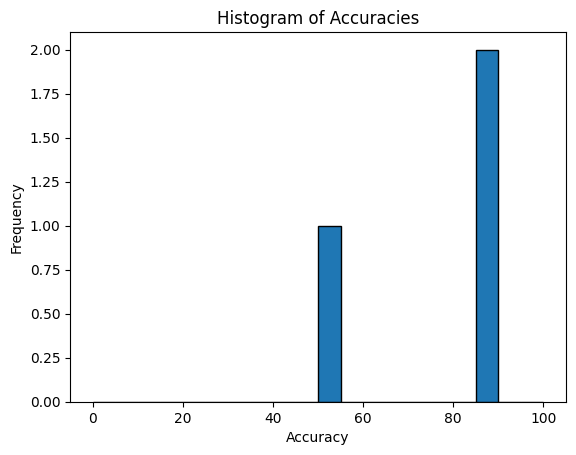

In [8]:
fig = hist_accuracies(df["Accuracy"])

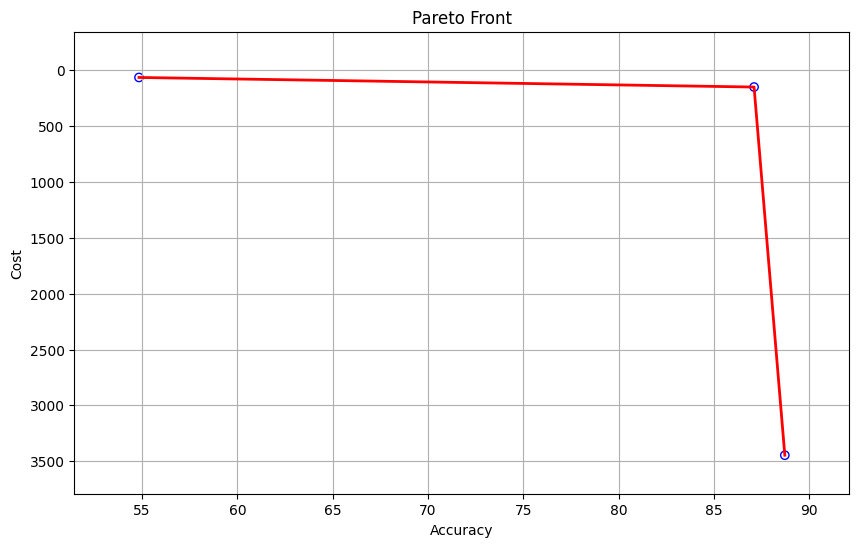

In [9]:
from src.nas import plot

fig = plot.plot_pareto_front(df["Accuracy"], df["Complexity"])

In [30]:
from src.models.eval import KFoldNNArchitectureEvaluator, NNArchitectureEvaluator

KFoldNNArchitectureEvaluator(params).evaluate_accuracy(times=3)

{'max': 90.3225806451613,
 'mean': np.float64(74.40860215053763),
 'std': np.float64(8.73287763623525),
 'accuracies': [72.58064516129032,
  70.96774193548387,
  79.03225806451613,
  58.064516129032256,
  67.74193548387096,
  62.903225806451616,
  67.74193548387096,
  80.64516129032258,
  79.03225806451613,
  88.70967741935483,
  75.80645161290323,
  77.41935483870968,
  79.03225806451613,
  66.12903225806451,
  90.3225806451613],
 'best_model': MLP(
   (layers): Sequential(
     (0): Quantize()
     (1): Linear(in_features=6, out_features=12, bias=True)
     (2): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (3): Dropout(p=0.2, inplace=False)
     (4): Identity()
     (5): Linear(in_features=12, out_features=12, bias=True)
     (6): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (7): Dropout(p=0.2, inplace=False)
     (8): Identity()
     (9): Linear(in_features=12, out_features=3, bias=True)
     (10): Batch

In [ ]:


accuracy, model = problem.best_architecture[tuple(df["Chromosome"].iloc[0])]

NNArchitectureEvaluator(params).test_model(model)

74.19354838709677